*This notebook was created by [Svitozar Serkez](http://www.xfel.eu/organization/staff/serkez_svitozar/). Source and license info is on [GitHub](https://github.com/sserkez/ocelot/tree/dev/docs). August 2016. *

# Tutorial N5:  Genesis preprocessor. 

### Ocelot is not only a particle tracking code, but a simulation toolkit.

Python is known to be a very good "glue" between different software

Interface to other codes may be (and was) developed.
GENESIS interface is under active development and is currently used for studies

-list of papers

![ocelot control figure](ocelot_control.png)

## This example will cover the following topics:
* Initialization  of the library
* Preparing the GENESIS simulation
* running many-stage statistical simulation

### Requirements
* OCELOT - library
* numpy, scipy, matplotlib
* beam.txt - input beam file

### Import of modules

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline
from __future__ import print_function
# this python library provides generic shallow (copy) and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot graphical modules
import sys, os
from ocelot import *
from ocelot.utils.xfel_utils import *
from ocelot.gui.accelerator import *
from ocelot.gui.genesis_plot import *
#from ocelot.optics.elements import Filter_freq

import numpy as np
from copy import copy
#import matplotlib.pyplot as plt
# load beam distribution

initializing ocelot...


### Setting input parameters
electron beam energy and expected radiation photon energy

In [2]:
E_beam=8.5 #[GeV]
E_photon=250 #[eV]

### Creating SASE3 lattice
with native ocelot objects

In [3]:
# defining the undulator
lperiod=0.068
nperiods=73
und = Undulator(lperiod=lperiod, nperiods=nperiods, Kx=1.0);
und.Kx = Ephoton2K(E_photon, und.lperiod, E_beam)

# defining of the drifts
d2 = Drift (l=4*und.lperiod)
d3 = Drift (l=7*und.lperiod)

# defining of the quads
qf = Quadrupole (l=6*und.lperiod, k1=-7.3)
qd = Quadrupole (l=6*und.lperiod, k1=7.3)
qdh=deepcopy(qd)
qdh.l/=2

# creating of the cell
extra_fodo = (und, d2, qdh)
cell_ps = (und, d2, qf, d3, und, d2, qd, d3)
l_fodo= MagneticLattice(cell_ps).totalLen/2
sase3 = MagneticLattice((und, d2, qd, d3) + 11*cell_ps)

up = UndulatorParameters(und,E_beam)
up.printParameters()

Undulator parameters:
('L=', 4.964)
('gamma(electron)=', 16634.085776399123)
('K=', 8.8723675084034621)
('B[T]=', 1.397364688791348)
('test', 250.00000000000003)
Radiation parameters:
('w1(first harmonic, zero angle)=', 3.7981687858557933e+17, 'Hz/2pi', 250.00000000000003, '[eV]', 4.959367720369577e-09, 'm')
('Total energy loss [Gev]', 0.00044305322825621829)


## Load beam file

In [5]:
beamf = read_beam_file('beam.dat')

['ZPOS', 'GAMMA0', 'DELGAM', 'EMITX', 'EMITY', 'BETAX', 'BETAY', 'XBEAM', 'YBEAM', 'PXBEAM', 'PYBEAM', 'ALPHAX', 'ALPHAY', 'CURPEAK', 'ELOSS']


## Plot beamfile

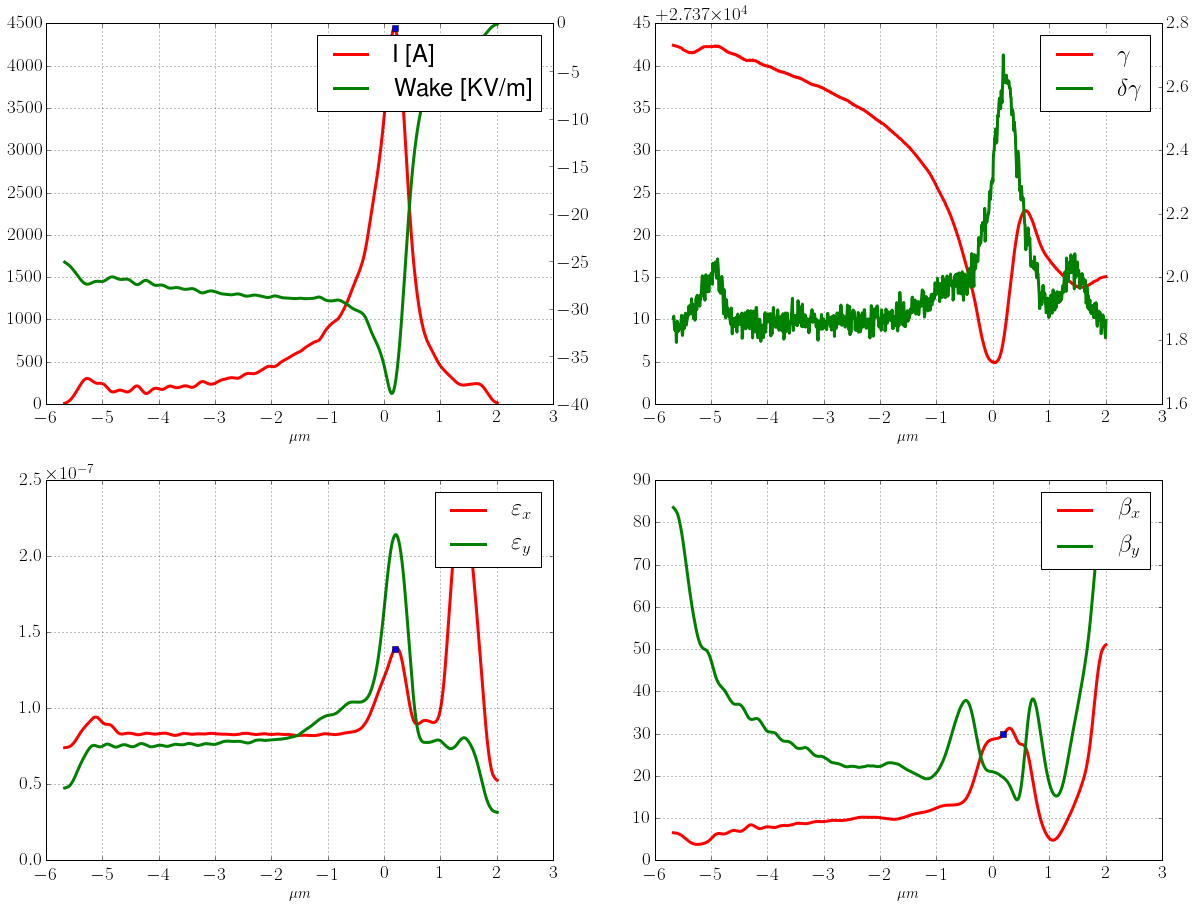

In [7]:
fig=plt.figure()
fig.set_size_inches((20,15))
plot_beam(fig, beamf)

## Match beam file

********* calculating fodo parameters *********
fodo parameters:
('k*l=', array([ 0.05283898,  0.15461945]))
('f=', 18.925420799442076, 6.4674915975241269)
('kap1=', 3.0923890195166788)
('kap2=', 1.0567796727980598)
('betaMax=', array([ 26.4674916,  38.9254208]))
('betaMin=', array([ 13.5325084,   1.0745792]))
('betaMean=', array([ 20.,  20.]))
*********                             *********
before rematching k=-7.300000 7.300000   beta=29.813443 19.628544 alpha=1.244151 -0.831963
after rematching k=0.259015 -0.259015   beta=24.470237 14.252958 alpha=1.325022 -0.880831
matching to slice 999
transforming


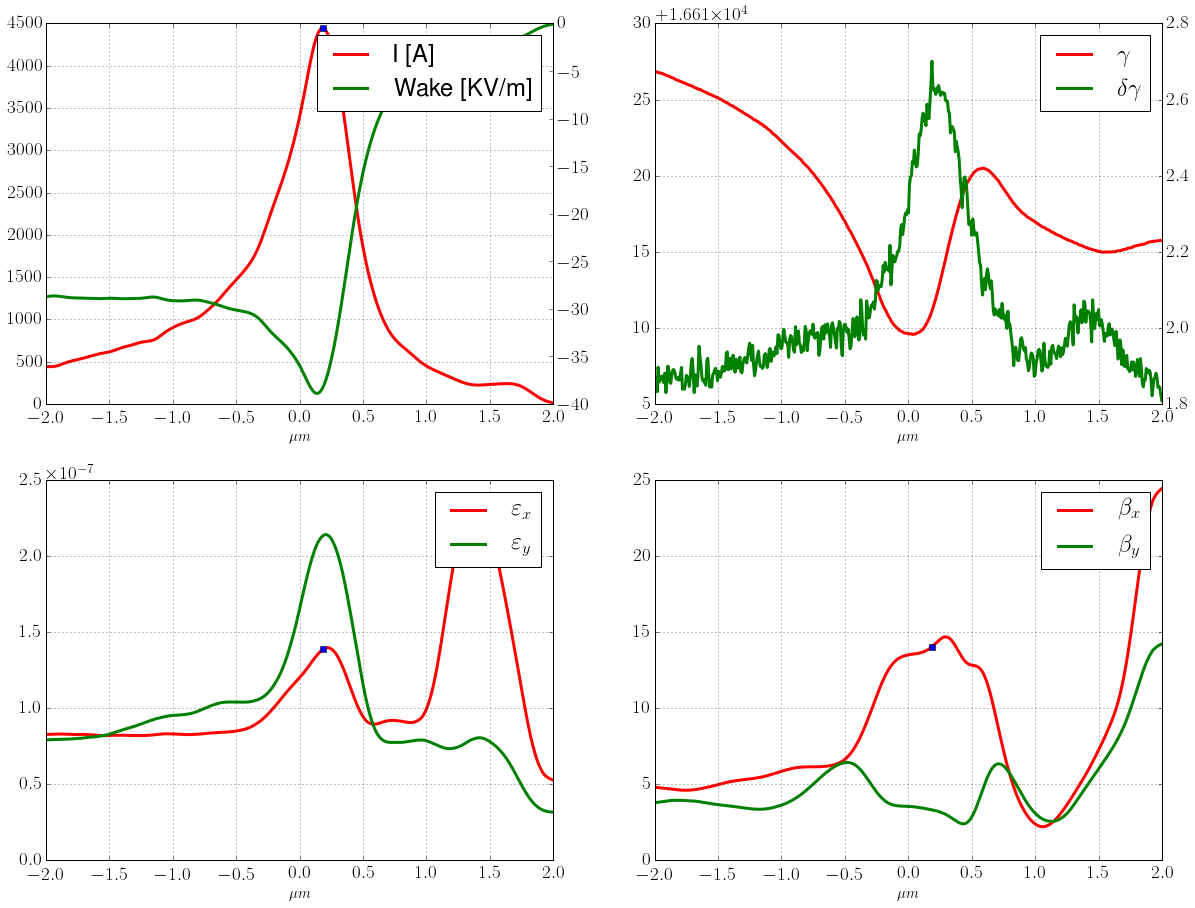

In [8]:
beta_av = 20.0
beam=get_beam_peak(beamf)
beam.E=E_beam
rematch(beta_av, l_fodo, qdh, sase3, extra_fodo, beam, qf, qd)
beamf = transform_beam_file(beamf ,transform = [ [beam.beta_x,beam.alpha_x], [beam.beta_y,beam.alpha_y] ], energy_new = beam.E, emit_scale = 1.0)
beamf = cut_beam(beamf,[-2e-6, 2e-6])

fig=plt.figure()
fig.set_size_inches((20,15))
plot_beam(fig, beamf)

## Tapering the undulator
linear, quadratic,power-law...

In [9]:
def f1(n, n0, a0, a1, a2):
    '''
    piecewise-quadratic tapering function
    '''
    for i in xrange(1,len(n0)):
        if n < n0[i]:
            return a0 + (n-n0[i-1])*a1[i-1] + (n-n0[i-1])**2 * a2[i-1]
        a0 += (n0[i]-n0[i-1])*a1[i-1] + (n0[i]-n0[i-1])**2 * a2[i-1]
    
    return 1.0

tap_start=3 #number of undulators
lin_tap=0.01 #taper step
quad_tap=0.0

n = 60
n0 = [0,tap_start,60]
a0 = und.Kx
a1 = [0,lin_tap*a0]
a2 = [0,quad_tap]

taper_func1 = lambda n : f1(n, n0, a0, a1, a2)

sase3= taper(sase3, taper_func1)

##### specify the run_dir - directory into which the experimental results will be saved

In [14]:
run_dir = 'gen_stst' #directory to dump data
run_id=0 # run number (subdirectory 'run_#') for statistical studies
try:
    os.makedirs(run_dir)
except:
    pass
launcher = get_genesis_launcher('genesis') # launcher object to start genesis

##### generate Genesis input object

In [15]:
inp = generate_input(up, beam, itdp=False)
inp.lattice_str = generate_lattice(sase3, unit = up.lw, energy = beam.E) #generate Genesis lattice based on Ocelot lattice object
inp.beam_file_str = beam_file_str(beamf)
#inp.beamfile = 'tmp.beam'

inp.runid = run_id
inp.run_dir = run_dir
inp.ipseed = 17111+7*run_id # defines shot-noise, changes automatically 
# below other Genesis parameters may be specified, like prad0, dgrid, etc.....

********    FEL Parameters    ********
ex= 1.38895798733e-07
ey= 2.13452762304e-07
rxbeam= 1.11421096629e-05  [m]
rybeam= 1.05416158084e-05  [m]
rel energy spread deta= 0.000162368283071  [m]
xlamd= 0.068
aw0= 6.27371123037
gamma0= 16634.1159848
Ip= 4445.33915304  beam peak current [A]
lambda0= 4.95934970746e-09
Pb= 3.77854513472e+13  beam power [W]
N= 153100.938649
rho= 0.00413668812369
power= 2577.28852613  equivalent shot noise power [W]
coupling parameter fc= 0.712953317588
gain length estimate lg= 0.755241144761
Rayleigh length estimate zr= 0.297846800745

Ming Xie gain reduction estimates:
diffraction parameter etad= 2.53566982379
energy spread parameter etad= 0.0226614550422
gain length degradation lscale= 0.766336177728
**************************************
generating lattice file...


now all the genesis input files are created, such as lattice file, beam file, input file.

In [16]:
print(inp.input())

 $newrun 
 aw0   =  6.27371123037 
 xkx   =  0
 xky   =  1
 wcoefz =  0 0 0
 xlamd =  0.068
 fbess0 =  0.712953317588
 delaw =  0
 iertyp =  0
 iwityp =  0
 awd   =  6.27371123037 
 awx   =  0
 awy   =  0
 iseed =  -1
 npart =  2048
 gamma0 =  16634.1159848
 delgam =  2.70085285285
 rxbeam =  1.11421096629e-05
 rybeam =  1.05416158084e-05
 alphax = 1.32502206016
 alphay = -0.880831166291
 emitx =  1.38895798733e-07
 emity =  2.13452762304e-07
 xbeam =  0.0
 ybeam =  0.0
 pxbeam =  0.0
 pybeam =  0.0
 conditx =  0.0
 condity =  0.0
 bunch =  0.0
 bunchphase =  0.0
 emod =  0.0
 emodphase =  0.0
 xlamds =  4.95934970746e-09
 prad0 =  0
 zrayl =  0.297846800745
 zwaist =  2
 ncar  =  151
 lbc   =  0
 rmax0 =  9.0
 dgrid =  0.0
 nscr  =  0
 nscz  =  0
 nptr  =   40
 nwig  =   98
 zsep  =   20
 delz  =   4.0
 nsec  =   1
 iorb  =   0
 zstop =   256.0
 magin =   1
 magout =   0
 quadf =   0
 quadd =   0
 fl    =  0
 dl    =  0
 drl   =  0
 f1st  =  0
 qfdx  =  0
 qfdy  =  0
 solen =  0
 sl  

In [17]:
print(inp.lattice_str)

# header is included
? VERSION= 1.00  including new format
? UNITLENGTH= 0.068 :unit length in header
AW    6.27371123037   73.0  0.0
AW    6.27371123037   73.0  17.0
AW    6.27371123037   73.0  17.0
AW    6.33644834267   73.0  17.0
AW    6.39918545498   73.0  17.0
AW    6.46192256728   73.0  17.0
AW    6.52465967959   73.0  17.0
AW    6.58739679189   73.0  17.0
AW    6.65013390419   73.0  17.0
AW    6.7128710165   73.0  17.0
AW    6.7756081288   73.0  17.0
AW    6.8383452411   73.0  17.0
AW    6.90108235341   73.0  17.0
AW    6.96381946571   73.0  17.0
AW    7.02655657802   73.0  17.0
AW    7.08929369032   73.0  17.0
AW    7.15203080262   73.0  17.0
AW    7.21476791493   73.0  17.0
AW    7.27750502723   73.0  17.0
AW    7.34024213953   73.0  17.0
AW    7.40297925184   73.0  17.0
AW    7.46571636414   73.0  17.0
AW    7.52845347645   73.0  17.0
AD    6.27371123037   17.0  73.0
AD    6.27371123037   17.0  73.0
AD    6.33644834267   17.0  73.0
AD    6.39918545498   17.0  73.0
AD    6.461

In [18]:
print(inp.beam_file_str)

# 
? VERSION = 1.0
? SIZE =521
? COLUMNS ZPOS GAMMA0 DELGAM EMITX EMITY BETAX BETAY XBEAM YBEAM PXBEAM PYBEAM ALPHAX ALPHAY CURPEAK ELOSS
-1.99578155155e-06 16636.8491332 1.86806646647 8.28193026263e-08 7.92424918988e-08 4.80748057486 3.80534285333 0.0 0.0 0.0 0.0 0.599355677268 0.712462798687 442.445184853 -28725.103293
-1.98809868869e-06 16636.8268689 1.86816506507 8.28118000853e-08 7.9281606531e-08 4.80025726799 3.80890738489 0.0 0.0 0.0 0.0 0.599792994783 0.71370350518 441.588856421 -28709.097391
-1.98041582583e-06 16636.8061321 1.83201981982 8.28122996212e-08 7.93198709845e-08 4.79181451684 3.81410553011 0.0 0.0 0.0 0.0 0.600111350976 0.715128676868 440.747637886 -28693.811591
-1.97273296296e-06 16636.7612831 1.89664444444 8.28251950231e-08 7.93520875772e-08 4.78298211531 3.82083584465 0.0 0.0 0.0 0.0 0.600517671324 0.71686418496 440.181218364 -28680.2052469
-1.9650501001e-06 16636.7647844 1.85702582583 8.28515996559e-08 7.93756996924e-08 4.77444896891 3.82896850927 0.0 0.0 0.0 0.

### Genesis may be executed with the following command:

In [19]:
#g = run(inp,launcher)

if "run" function is placed in a sctipt, the following post-processing code will be executed after the GENESIS simulation is finished

the following two python scripts would start ocelot/genesis several-stage simulation for many independent runs

Possible post-processing between stages:
* electron beam:  propagation through chicane via second-order tracking +CSR (in development)
* radiation: hard X-ray Self-seeding
* radiation: soft X-ray Self-seeding (in development)

In [10]:
exp_dir='/some_directory'

run_number=10
run_ids = xrange(0,run_number)

start_stage = 1
stop_stage = 4

# set simulation parameters
# prepare electron beam file

stage=1
if start_stage <= stage and stop_stage >= stage:
    for run_id in run_ids:   
        run_dir = exp_dir + 'run_' + str(run_id)    
        #prepare input, specify parameters
        #inp.ipseed = 17111*(run_id + 1)
        #
        #
        #
        #g = run(inp,launcher)
        print('run #',run_id, ' of stage ',stage)
        
stage=2
if start_stage <= stage and stop_stage >= stage:
    for run_id in run_ids:   
        run_dir = exp_dir + 'run_' + str(run_id)    
        #prepare input based on stage 1 output
        #inp.ipseed = 27222*(run_id + 1)
        #
        #inp.distfile = 'run.'+ str(inp.runid)+'.s1.gout.dist'
        #
        #g = run(inp,launcher)
        print('run #',run_id, ' of stage ',stage)
        
stage=3
if start_stage <= stage and stop_stage >= stage:
    for run_id in run_ids:   
        run_dir = exp_dir + 'run_' + str(run_id)    
        #prepare input based on stage 1 output
        #inp.ipseed = 37333*(run_id + 1)
        #
        #inp.distfile = 'run.'+ str(inp.runid)+'.s1.gout.dist'
        #
        #g = run(inp,launcher)
        print('run #',run_id, ' of stage ',stage)
    
    #stage=n .........

run # 0  of stage  1
run # 1  of stage  1
run # 2  of stage  1
run # 3  of stage  1
run # 4  of stage  1
run # 5  of stage  1
run # 6  of stage  1
run # 7  of stage  1
run # 8  of stage  1
run # 9  of stage  1
run # 0  of stage  2
run # 1  of stage  2
run # 2  of stage  2
run # 3  of stage  2
run # 4  of stage  2
run # 5  of stage  2
run # 6  of stage  2
run # 7  of stage  2
run # 8  of stage  2
run # 9  of stage  2
run # 0  of stage  3
run # 1  of stage  3
run # 2  of stage  3
run # 3  of stage  3
run # 4  of stage  3
run # 5  of stage  3
run # 6  of stage  3
run # 7  of stage  3
run # 8  of stage  3
run # 9  of stage  3


### next: Tutorial N6: Genesis_postprocessor